<a href="https://colab.research.google.com/github/thiagotandrade/ds_project/blob/master/DS_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO: 

# 1.   VISUALIZAR A DISPERSÃO DOS ERROS
# 1.   COPIAR OUTROS KERNELS E VER DESEMPENHO

[fine tuning xgboost hyperparameters](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)


[another tutorial on fine tuning xgboost hyperparameters](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)

# Competição do Kaggle: [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1)

# Initial Setup

In [0]:
import os
import warnings
import xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

%matplotlib inline
warnings.filterwarnings("ignore")

In [0]:
props = pd.read_csv('../input/props.csv', header=0, sep=',', quotechar='"')

In [0]:
props.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,548.0,1264.0,1264.0,NaN,NaN,548.0,NaN,6111.0,NaN,2.0,2.0,0.0,NaN,NaN,34303597.0,-119287236.0,1735.0,NaN,NaN,NaN,NaN,NaN,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,5.0,NaN,1.0,NaN,NaN,128.0,NaN,1986.0,2.0,NaN,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,777.0,777.0,777.0,NaN,NaN,777.0,NaN,6111.0,NaN,1.0,1.0,0.0,NaN,NaN,34272866.0,-119198911.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,4.0,NaN,NaN,NaN,NaN,198.0,NaN,1990.0,1.0,NaN,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,1101.0,1101.0,1101.0,NaN,NaN,1101.0,NaN,6111.0,NaN,2.0,2.0,441.0,NaN,NaN,34340801.0,-119079610.0,6569.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1956.0,1.0,NaN,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,1554.0,1554.0,1554.0,NaN,NaN,1554.0,NaN,6111.0,1.0,1.0,2.0,460.0,NaN,NaN,34354313.0,-119076405.0,7400.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,NaN,1.0,NaN,NaN,NaN,NaN,1965.0,1.0,NaN,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,2016-06-07
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,1305.0,2415.0,2415.0,NaN,NaN,1305.0,NaN,6111.0,1.0,2.0,2.0,665.0,NaN,NaN,34266578.0,-119165392.0,6326.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97084.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1984.0,2.0,NaN,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,2016-08-08


# Definição de tipos

In [0]:
object_type = props.select_dtypes(include=['object']).columns.values
props[object_type] = props[object_type].astype('category')

#Mudar tipo da coluna transaction date para 'datetime64' e separando a data em colunas
props['transactiondate'] = pd.to_datetime(props['transactiondate'])
props['transaction_year'] = props['transactiondate'].dt.year
props['transaction_month'] = props['transactiondate'].dt.month
props['transaction_day'] = props['transactiondate'].dt.day
props['transactiondate_quarter'] = props['transactiondate'].dt.quarter
props.drop(['transactiondate'], axis=1, inplace=True)

# Remoção de dados ausentes

In [0]:
#A coluna 'fireplaceflag' não adiciona nenhuma informação útil pois o dataset já possui 'fireplacecnt', então removemos:
props.drop(['fireplaceflag'], axis=1, inplace=True)

#A coluna 'calculatedbathnbr' é uma cópia da coluna 'bathroomcnt', então removemos:
props.drop(['calculatedbathnbr'], axis=1, inplace=True)

#A coluna 'calculatedfinishedsquarefeet' é uma cópia da coluna 'finishedsquarefeet12', então removemos:
props.drop(['calculatedfinishedsquarefeet'], axis=1, inplace=True)

# Remover colunas com mais de 70% de dados ausentes
props.dropna(thresh=0.70*len(props), axis=1, inplace=True)

props.dropna(inplace=True)

In [0]:
props.shape

(5653, 28)

In [0]:
props.isnull().values.any()

False

In [0]:
props.head()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day,transactiondate_quarter
0,17073783,2.5,3.0,1264.0,6111.0,2.0,34303597.0,-119287236.0,1735.0,1128,265.0,6.111002e+07,34543.0,2061.0,97081.0,5.0,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953,2016.0,1.0,27.0,1.0
2,17100444,2.0,3.0,1101.0,6111.0,2.0,34340801.0,-119079610.0,6569.0,1111,261.0,6.111001e+07,26965.0,2061.0,97113.0,5.0,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060,2016.0,5.0,27.0,2.0
3,17102429,1.5,2.0,1554.0,6111.0,1.0,34354313.0,-119076405.0,7400.0,1110,261.0,6.111001e+07,26965.0,2061.0,97113.0,5.0,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566,2016.0,6.0,7.0,2.0
4,17109604,2.5,4.0,2415.0,6111.0,2.0,34266578.0,-119165392.0,6326.0,1111,261.0,6.111001e+07,34543.0,2061.0,97084.0,8.0,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573,2016.0,8.0,8.0,3.0
5,17125829,2.5,4.0,2882.0,6111.0,2.0,34240014.0,-119024793.0,10000.0,1111,261.0,6.111005e+07,51239.0,2061.0,97089.0,8.0,1980.0,222070.0,289609.0,2015.0,67539.0,3110.44,6.111005e+13,0.0564,2016.0,8.0,26.0,3.0


# Definição de Tipos

# Normalizando dados

# Separando em conjuntos de treinamento e teste

In [0]:
X = props.drop(['logerror'],axis=1)
y = props['logerror']

In [0]:
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Linear Regressor para servir como baseline

In [0]:
def linearRegressor(X_train, Y_train, X_test, Y_test):
  regressor = LinearRegression(fit_intercept=True)

  model = regressor.fit(X_train, Y_train)

  pred_LR = regressor.predict(X_test)
  
  plt.scatter(Y_test, pred_LR)
  plt.xlabel("True Values")
  plt.ylabel("Predictions")
  
  resultados(Y_test, pred_LR)

# Random Forest Regressor

In [0]:
def randomForestRegressor(X_train, Y_train, X_test, Y_test):
  # Gerar conjuntos de validação-cruzada para o treinamento de dados
  cv_sets = ShuffleSplit(n_splits=10, test_size = 0.25)

  #n_estimators =10
  rfr =  RandomForestRegressor(n_estimators=10, random_state=42)

  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
  # Number of features to consider at every split
  max_features = ['auto', 'sqrt']
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
  # max_depth.append(None)
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10, 15, 100]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 5, 10]
  # Method of selecting samples for training each tree
  # bootstrap = [True, False]

  # Create the random grid
  params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf}

  #Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
  scoring_fnc = make_scorer(mean_absolute_error)

  # Gerar o objeto de busca em matriz
  grid = RandomizedSearchCV(estimator = rfr, param_distributions = params, scoring=scoring_fnc, cv=cv_sets, n_iter = 100, verbose=2)

  # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
  grid = grid.fit(X_train, Y_train)

  # Escolher o melhor estimador para predizer os dados de teste
  best_rfr = grid.best_estimator_

  print("Best Estimator: \n{}\n".format(grid.best_estimator_))
  print("Best Parameters: \n{}\n".format(grid.best_params_))

  pred_RFR = best_rfr.predict(X_test)
  
  resultados(Y_test, pred_RFR)

# XGBOOST

In [0]:
def xgb(X_train, Y_train, X_test, Y_test):
  model = xgboost.XGBRegressor(max_depth=17, gamma=0.3, learning_rate= 0.1)
  model.fit(X_train, Y_train)
  xgboost.plot_importance(model)
  pred_xgb = model.predict(X_test)
  resultados(Y_test, pred_xgb)

# Função para imprimir resultados dos modelos

In [0]:
def resultados(Y_test, predictions):
  
  #calculando o erro de uma árvore de decisão para regressão:
  mae_RFR = mean_absolute_error(predictions, Y_test)
  print ("Erro médio absoluto: {}".format(mae_RFR))

  #Acurácia do modelo
  r2_RFR = r2_score(predictions, Y_test)
  print ("Índice R² (score): {}".format(r2_RFR))
  
  plt.figure()  
  sns.set(style="whitegrid")
  # Plot the residuals after fitting
  sns.residplot(predictions, Y_test, color="g")

# Filtrando dataset em relação ao munícipio com mais propriedades

### Encontrando o município que possui mais propriedades

In [0]:
props.propertycountylandusecode.value_counts()[props.propertycountylandusecode.value_counts() >0].head(10)

0100    2344
122     1087
010C     695
0101     550
1111     315
010E     166
010D     130
1         86
1110      70
34        36
Name: propertycountylandusecode, dtype: int64

In [0]:
props.propertycountylandusecode.value_counts().argmax()

'0100'

### props_county são as propriedades do município que contém mais casas

In [0]:
props_county = props[props.propertycountylandusecode == props.propertycountylandusecode.value_counts().argmax()]
props_county.drop(['propertycountylandusecode'], axis=1, inplace=True)

In [0]:
props_county.shape

(2344, 27)

In [0]:
props_county.head()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day,transactiondate_quarter
27,10727091,2.0,3.0,1160.0,6037.0,2.0,34188121.0,-118646361.0,7688.0,261.0,6.037135e+07,12447.0,3101.0,96342.0,0.0,1960.0,105045.0,437584.0,2015.0,332539.0,5421.96,6.037135e+13,0.0030,2016.0,10.0,14.0,4.0
28,10730788,2.0,4.0,1570.0,6037.0,2.0,34188446.0,-118616724.0,11308.0,261.0,6.037135e+07,12447.0,3101.0,96342.0,0.0,1959.0,115379.0,397138.0,2015.0,281759.0,5097.78,6.037135e+13,-0.0020,2016.0,7.0,1.0,3.0
32,10760933,2.0,4.0,1212.0,6037.0,2.0,34220631.0,-118521001.0,7379.0,261.0,6.037131e+07,12447.0,3101.0,96355.0,0.0,1954.0,32615.0,56867.0,2015.0,24252.0,4560.02,6.037131e+13,-0.1244,2016.0,6.0,27.0,2.0
33,10772282,3.0,4.0,2597.0,6037.0,3.0,34209413.0,-118578052.0,10537.0,261.0,6.037134e+07,12447.0,3101.0,96341.0,0.0,1964.0,234987.0,391643.0,2015.0,156656.0,4998.86,6.037134e+13,0.0545,2016.0,4.0,15.0,2.0
34,10783331,2.0,3.0,1742.0,6037.0,2.0,34185891.0,-118550426.0,7076.0,261.0,6.037133e+07,12447.0,3101.0,96364.0,0.0,1953.0,192864.0,471448.0,2015.0,278584.0,5784.98,6.037133e+13,0.0070,2016.0,2.0,25.0,1.0


In [0]:
props_county.describe()

,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transaction_year,transaction_month,transaction_day,transactiondate_quarter
count,2.344000e+03,2344.000000,2344.000000,2344.000000,2344.0,2344.000000,2.344000e+03,2.344000e+03,2344.000000,2344.0,2.344000e+03,2344.000000,2344.0,2344.000000,2344.0,2344.000000,2.344000e+03,2.344000e+03,2344.0,2.344000e+03,2344.000000,2.344000e+03,2344.000000,2344.0,2344.000000,2344.000000,2344.000000
mean,1.192160e+07,1.988908,3.077645,1629.866894,6037.0,1.988908,3.410875e+07,-1.182240e+08,9298.603669,261.0,6.037462e+07,35013.481655,3101.0,96376.772184,0.0,1954.729096,1.388463e+05,3.776625e+05,2015.0,2.388161e+05,5389.439983,6.037463e+13,0.018961,2016.0,5.869027,16.307594,2.285836
std,7.080519e+05,0.856725,0.857760,734.922599,0.0,0.856725,2.387296e+05,2.045249e+05,17345.861556,0.0,2.480628e+03,56416.757967,0.0,382.957531,0.0,22.883876,1.437642e+05,4.229484e+05,0.0,3.102218e+05,7132.756212,2.480867e+09,0.190906,0.0,2.844287,9.085294,0.945481
min,1.071438e+07,1.000000,0.000000,432.000000,6037.0,1.000000,3.370999e+07,-1.189082e+08,1121.000000,261.0,6.037101e+07,4406.000000,3101.0,95982.000000,0.0,1890.000000,1.019000e+03,1.112200e+04,2015.0,3.700000e+03,287.170000,6.037101e+13,-1.737000,2016.0,1.000000,1.000000,1.000000
25%,1.126846e+07,1.000000,3.000000,1148.000000,6037.0,1.000000,3.393775e+07,-1.183762e+08,5501.750000,261.0,6.037240e+07,12447.000000,3101.0,96121.000000,0.0,1941.000000,6.267400e+04,1.393300e+05,2015.0,4.818900e+04,2535.027500,6.037241e+13,-0.030500,2016.0,4.000000,8.000000,2.000000
50%,1.196765e+07,2.000000,3.000000,1457.000000,6037.0,2.000000,3.407139e+07,-1.182228e+08,6610.000000,261.0,6.037461e+07,16677.000000,3101.0,96268.000000,0.0,1953.000000,1.046545e+05,2.790000e+05,2015.0,1.551905e+05,4128.180000,6.037461e+13,0.005000,2016.0,6.000000,16.000000,2.000000
75%,1.252388e+07,2.000000,4.000000,1884.000000,6037.0,2.000000,3.419415e+07,-1.180911e+08,8195.500000,261.0,6.037577e+07,45398.000000,3101.0,96465.000000,0.0,1964.000000,1.647450e+05,4.520000e+05,2015.0,3.088650e+05,6180.585000,6.037577e+13,0.042100,2016.0,8.000000,24.000000,3.000000
max,1.309793e+07,7.000000,7.000000,8163.000000,6037.0,7.000000,3.476244e+07,-1.176521e+08,444403.000000,261.0,6.037930e+07,396556.000000,3101.0,97344.000000,0.0,2011.000000,1.933256e+06,6.935864e+06,2015.0,5.201898e+06,248725.740000,6.037930e+13,2.758000,2016.0,12.000000,31.000000,4.000000


In [0]:
ids = props_county.parcelid
X_train, X_test, Y_train, Y_test = train_test_split(props_county.drop(['logerror', 'parcelid'], axis=1), props_county.logerror, test_size=1/3, random_state=42)

In [0]:
# Se já rodou o gridsearch para determinar melhor estimador, deixar comentado
#randomForestRegressor(X_train, Y_train, X_test, Y_test)

'''
Best Parameters: 
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 25}

Best Test Score: 
0.10010858167899093
'''

"\nBest Parameters: \n{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 25}\n\nBest Test Score: \n0.10010858167899093\n"

Erro médio absoluto: 0.08944505453396136
Índice R² (score): -2.99296399188032


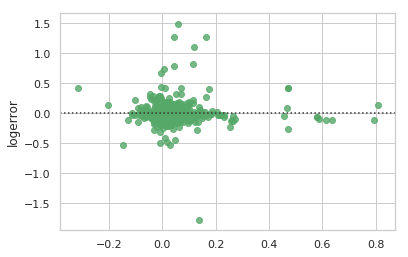

In [0]:
# Comentar esta célula caso deseje utilizar o gridsearch para tunar hiperparametros

# Modelo com hiperparametros tunados
best_rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

best_rfr.fit(X_train, Y_train)
predictions_best_rfr = best_rfr.predict(X_test)
resultados(Y_test, predictions_best_rfr)





Erro médio absoluto: 0.07815051430668678
Índice R² (score): -14.846726698720582


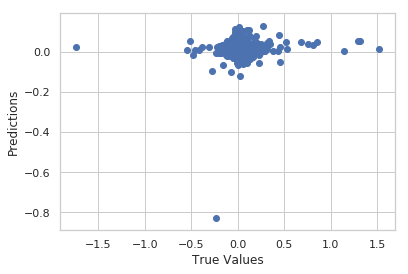

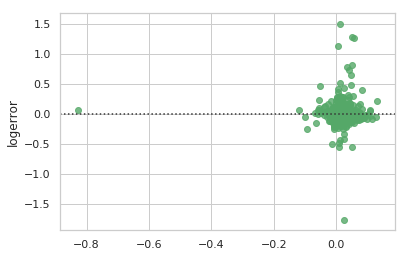

In [0]:
linearRegressor(X_train, Y_train, X_test, Y_test)

Erro médio absoluto: 0.09228856442681968
Índice R² (score): -1.6893699052643365


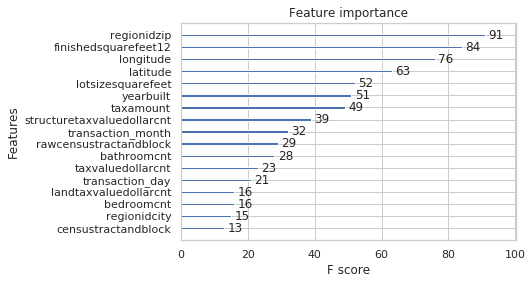

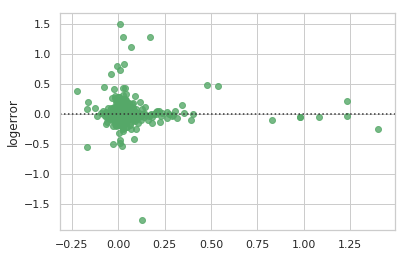

In [0]:
xgb(X_train, Y_train, X_test, Y_test)